In [6]:
from all_imports import *
import _modules 

from _modules.plotColors import *


participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

# Convert datetime column to 'Asia/Singapore' timezone using tz_convert
participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
print(participant_data_local_df['index_time'].dtype) 
display(participant_data_local_df['index_time']) 

#Cull data here by time per grouped id_participant for no duplicate index date 
# display(participant_data_local_df['c_total_valid_data'].describe())
# print(participant_data_local_df['c_total_valid_data'].dtypes)
participant_data_local_df = participant_data_local_df[participant_data_local_df['c_total_valid_data']]

#Cull data that is not from a run or from thermal history.

whitelistParticipants = ['esse00', 'esse01', 'esse03', 'esse04', 'esse05', 'esse06']

C:\Users\gottk\AppData\Local\Temp\ipykernel_17976\1413449838.py:7: DtypeWarning: Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.
  participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])


datetime64[ns, Asia/Singapore]


0               2023-11-22 22:41:56+08:00
1               2023-11-22 22:42:31+08:00
2               2023-11-22 22:43:34+08:00
3               2023-11-22 22:44:14+08:00
4               2023-11-22 22:48:21+08:00
                       ...               
497795          2024-04-09 16:55:00+08:00
497796   2024-04-09 16:55:01.194000+08:00
497797   2024-04-09 16:55:24.390000+08:00
497798   2024-04-09 17:00:04.049000+08:00
497799   2024-04-09 17:00:07.878000+08:00
Name: index_time, Length: 497800, dtype: datetime64[ns, Asia/Singapore]

#### Display of Average Data per Run by participants

AveParticipantData_df

,c_time_difference_between_locations
count,6.176000e+03
mean,5.136017e+03
std,3.597415e+04
min,1.000000e-03
25%,2.100000e+01
50%,7.828300e+01
75%,2.200930e+02
max,1.041274e+06


C:\Users\gottk\AppData\Local\Temp\ipykernel_17976\857276888.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_computed_df['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes


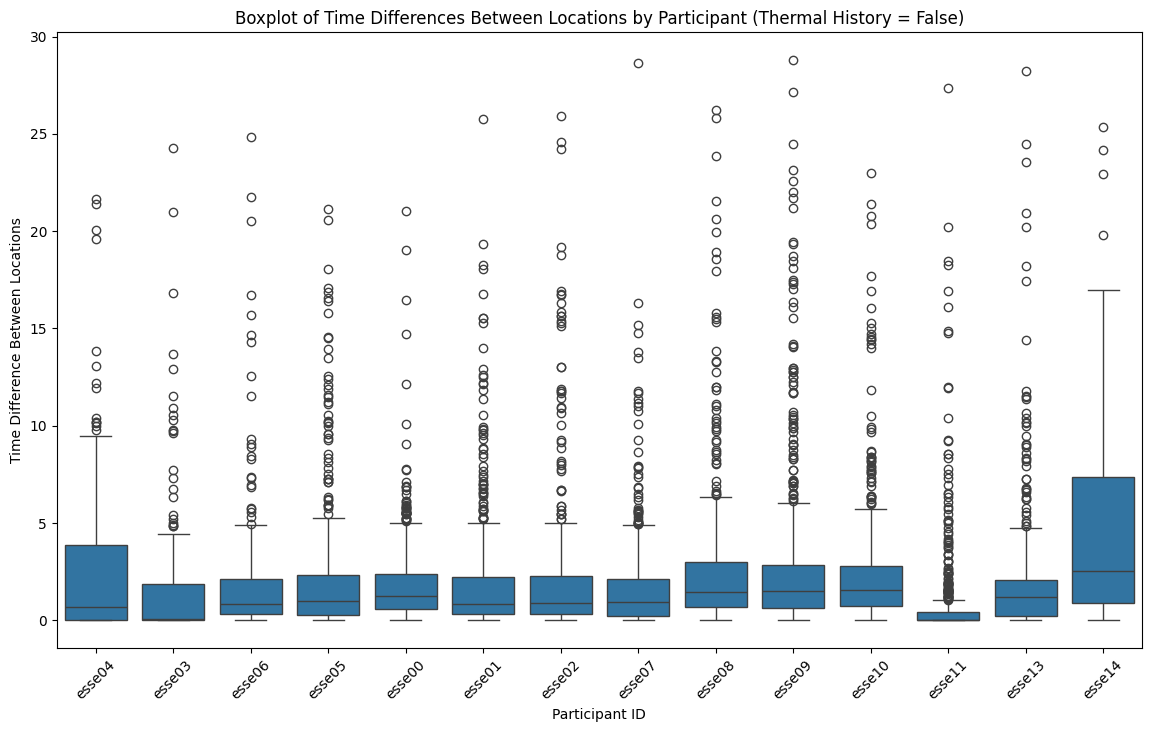

C:\Users\gottk\AppData\Local\Temp\ipykernel_17976\857276888.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_computed_df_with['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes


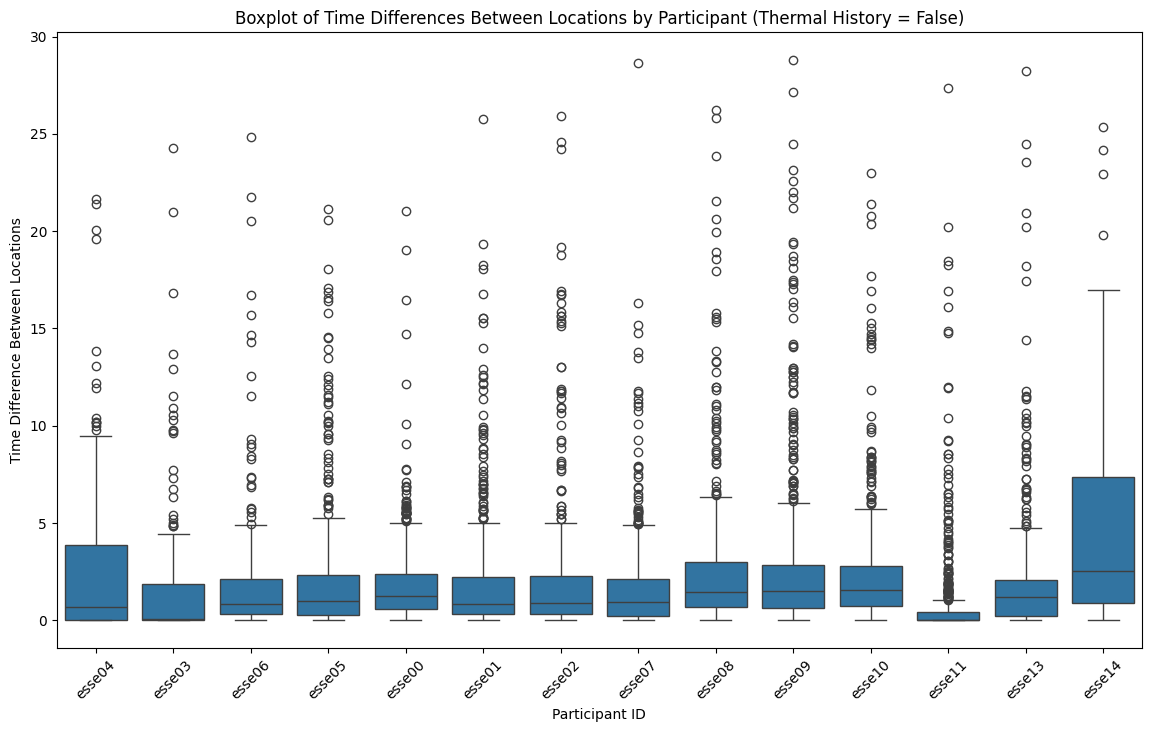

In [17]:
# Assuming you've already loaded participant_data_local_df
df = participant_data_local_df[['index_time', 'id_participant', 'c_longitude', 'c_latitude', 
                                'c_thermalhistory', 'run_valid', 'Scoria_horizontal_accuracy', 
                                'ws_location_accuracy_horizontal']].copy()

df['c_horizontal_accuracy'] = df['Scoria_horizontal_accuracy'] + df['ws_location_accuracy_horizontal']
df.to_csv('df.csv')  # Save a copy of df if needed

df = df.dropna(subset=['c_longitude'])
df = df.sort_values('index_time')
df = df[df['c_thermalhistory'] == False]

grouped_df = df.groupby(['id_participant'])

# Compute time differences
computed_df = grouped_df['index_time'].diff().dt.total_seconds().to_frame(name='c_time_difference_between_locations')
computed_df['id_participant'] = df['id_participant']  # Add id_participant back to computed_df
computed_df_with = computed_df.copy()

computed_df.dropna(subset=['c_time_difference_between_locations'], inplace=True)

computed_df.to_csv('test.csv')  # Save computed_df if needed
display(computed_df.describe())

# Filter based on time difference criteria
filtered_computed_df = computed_df[computed_df['c_time_difference_between_locations'] <= 1800]
filtered_computed_df['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes

# Create boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_computed_df, x='id_participant', y='c_time_difference_between_locations')
plt.title('Boxplot of Time Differences Between Locations by Participant (Thermal History = False)')
plt.xlabel('Participant ID')
plt.ylabel('Time Difference Between Locations')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()


filtered_computed_df_with = computed_df_with[computed_df_with['c_time_difference_between_locations'] <= 1800]
filtered_computed_df_with['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes

# Create boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_computed_df_with, x='id_participant', y='c_time_difference_between_locations')
plt.title('Boxplot of Time Differences Between Locations by Participant (Thermal History = True)')
plt.xlabel('Participant ID')
plt.ylabel('Time Difference Between Locations')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()



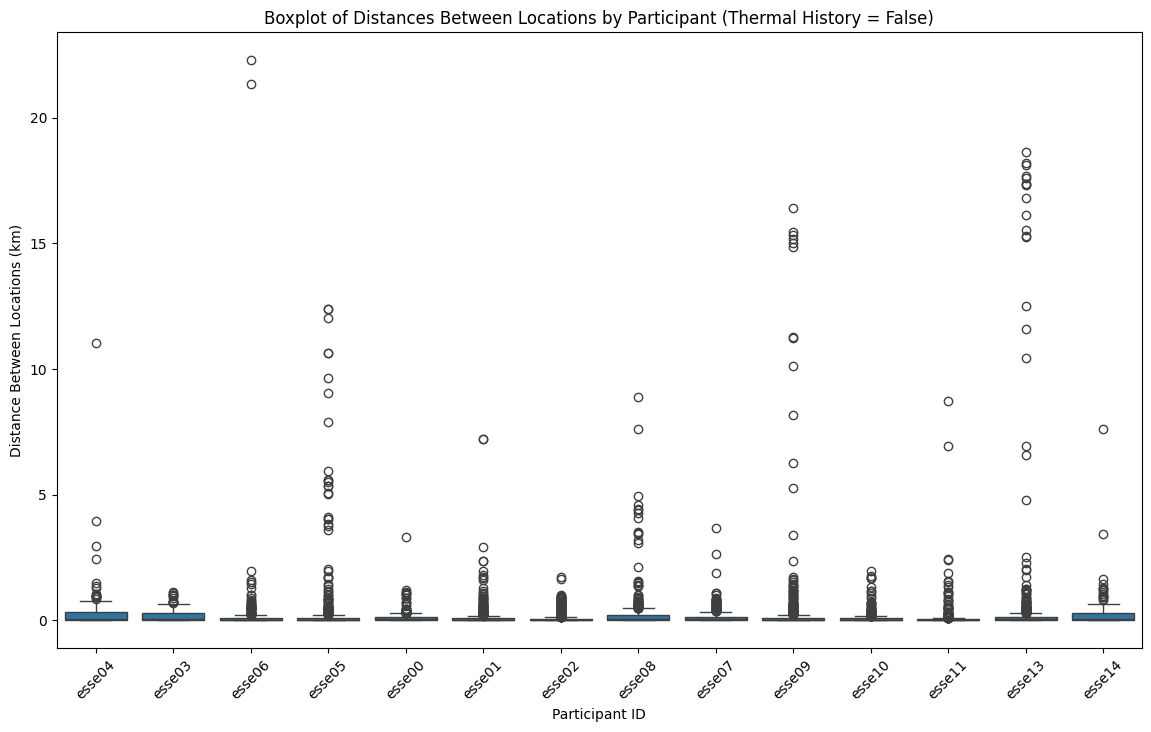

In [13]:
# ------> #INFO DISTANCE BETWEEN LOCATION POINTS
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
from haversine import haversine, Unit

# Function to calculate Haversine distance between two points
def calculate_haversine(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS)

# Create a copy of the specified columns
df = participant_data_local_df[['index_time', 'id_participant', 'c_longitude', 'c_latitude', 'c_thermalhistory', 'run_valid']].copy()

# Drop rows where 'c_longitude' or 'c_latitude' is NaN
df = df.dropna(subset=['c_longitude', 'c_latitude'])

# Sort the DataFrame by 'index_time' to ensure correct distance calculation
df = df.sort_values('index_time')

# Filter the DataFrame to include only rows where 'c_thermalhistory' is False
df = df[df['c_thermalhistory'] == False]

# Calculate distances between consecutive points for each participant
df['c_latitude_shift'] = df.groupby('id_participant')['c_latitude'].shift(-1)
df['c_longitude_shift'] = df.groupby('id_participant')['c_longitude'].shift(-1)

df['distance_between_points'] = df.apply(lambda row: calculate_haversine(row['c_latitude'], row['c_longitude'],
                                                                            row['c_latitude_shift'], row['c_longitude_shift']), axis=1)

# Drop the last row for each participant since it has NaN for shifted values
df = df.dropna(subset=['distance_between_points'])

# Filter out values above a certain threshold in meters (e.g., 2000 meters)
filtered_df = df[df['distance_between_points'] <= 2000]


# Create a boxplot with 'id_participant' on the x-axis for filtered data
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df, x='id_participant', y='distance_between_points')
plt.title('Boxplot of Distances Between Locations by Participant (Thermal History = False)')
plt.xlabel('Participant ID')
plt.ylabel('Distance Between Locations (km)')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

,ws_HR,ts_HR,ts_HRV,ws_HRV,ts_RHR,ws_RHR,ws_OS,ts_OS
id_participant,,,,,,,,
esse00,6033,6066,6,6,2,2,3,3
esse01,313,318,7,7,1,1,0,0
esse02,981,1331,15,14,0,0,10,10
esse03,1100,964,6,8,0,0,0,0
esse04,239,257,2,2,2,1,0,0
esse05,1118,1186,2,2,1,1,0,0
esse06,1409,1382,5,5,2,2,0,0
esse07,863,981,8,7,2,2,0,0
esse08,1510,330,2,2,0,0,0,0


ws_HR      981
ts_HR     1331
ts_HRV      15
ws_HRV      14
ts_RHR       0
ws_RHR       0
ws_OS       10
ts_OS       10
Name: esse02, dtype: int64

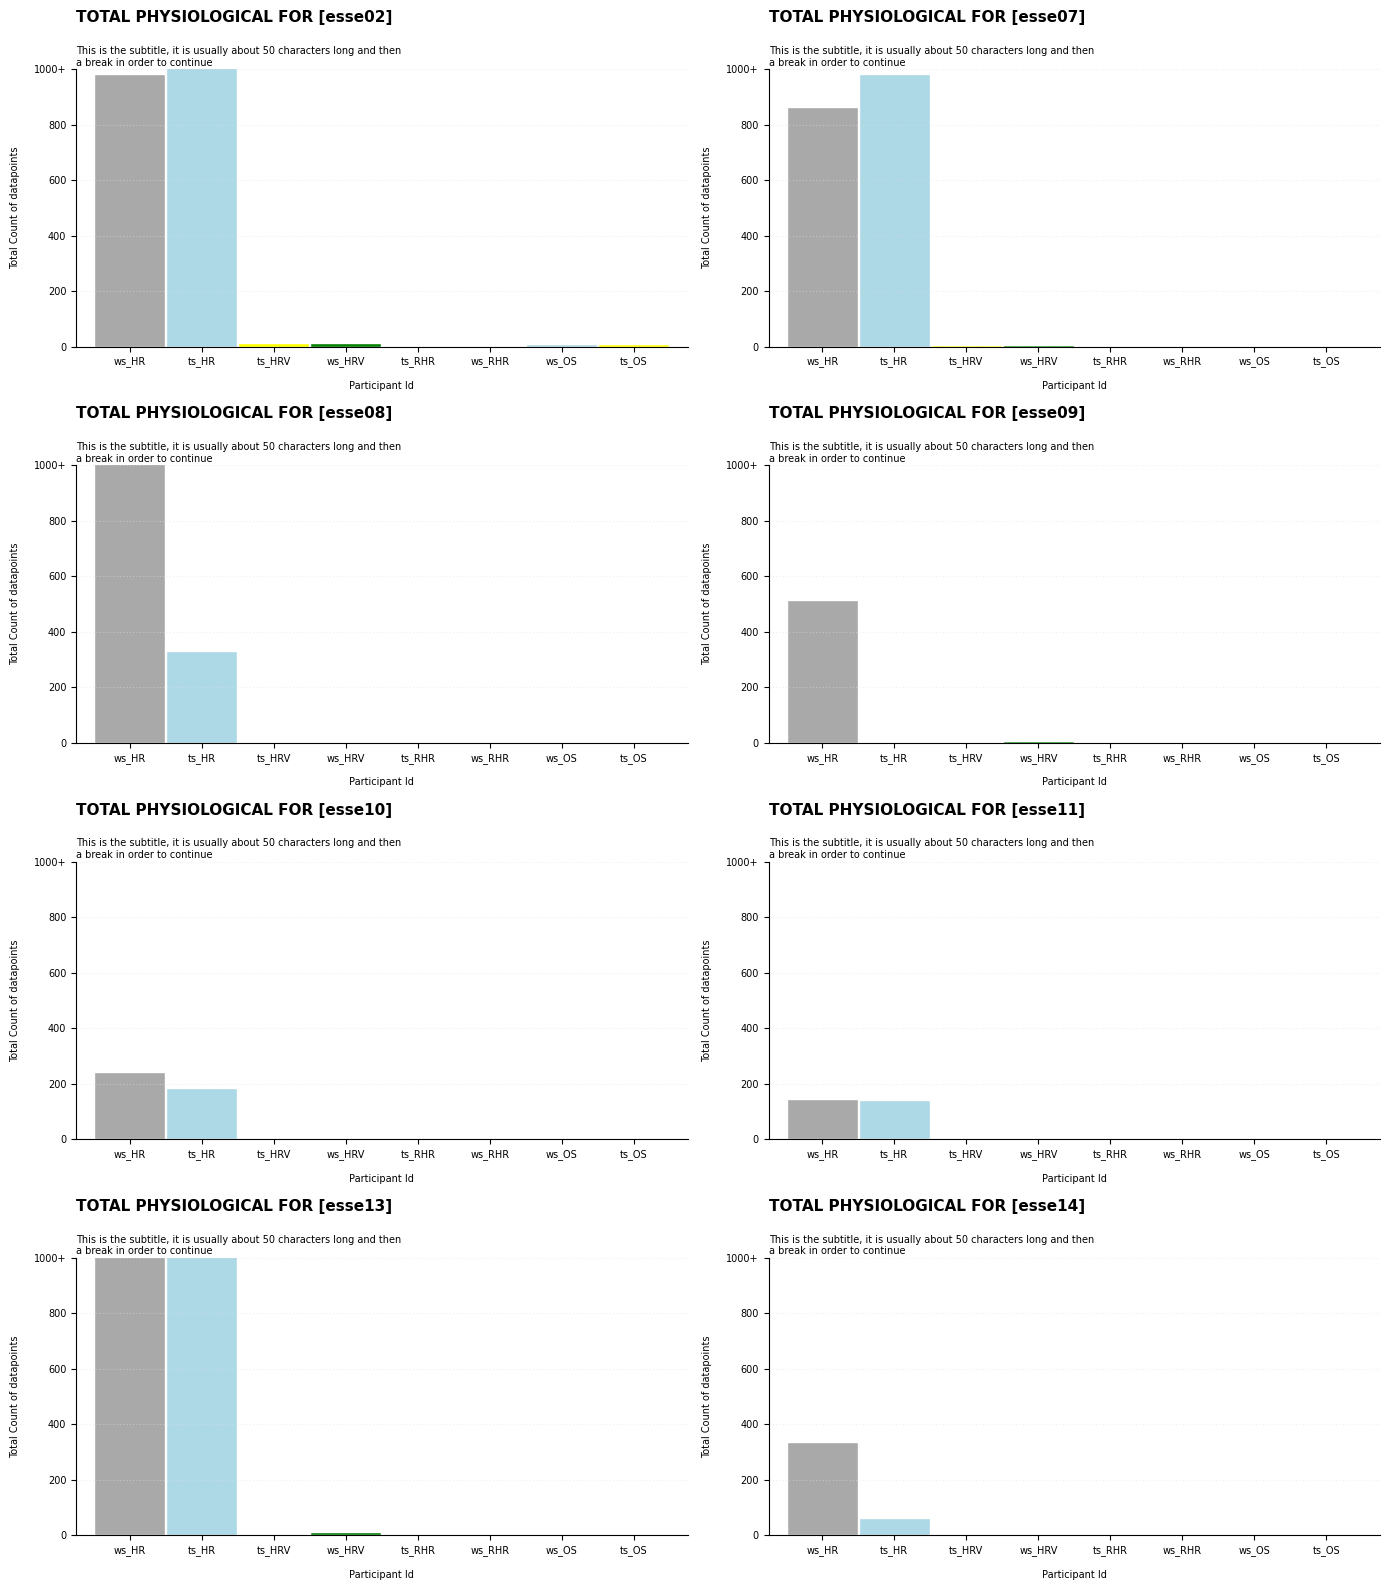

In [18]:
genColumns = ['id_participant']
physioColumns = ['ws_heart_rate', 'ts_heart_rate', 'ts_HRV', 'ws_HRV', 'ts_resting_heart_rate', 'ws_resting_heart_rate', 'ws_oxygen_saturation', 'ts_oxygen_saturation']
selColumns = genColumns + physioColumns
df = participant_data_local_df[selColumns].copy()

renaming = {'ws_heart_rate': 'ws_HR', 'ts_heart_rate': 'ts_HR',
            'ws_resting_heart_rate': 'ws_RHR', 'ts_resting_heart_rate': 'ts_RHR',
            'ws_oxygen_saturation': 'ws_OS', 'ts_oxygen_saturation': 'ts_OS'}
            # HRV does not need renaming

# Rename columns using rename() function
df.rename(columns=renaming, inplace=True)

#df = df[~df['id_participant'].isin(whitelistParticipants)]
grouped_df = df.groupby(['id_participant']).count()

display(grouped_df)

ESSE02_AveParticipantData_df = grouped_df.loc['esse02']
ESSE07_AveParticipantData_df = grouped_df.loc['esse07']
ESSE08_AveParticipantData_df = grouped_df.loc['esse08']
ESSE09_AveParticipantData_df = grouped_df.loc['esse09']
ESSE10_AveParticipantData_df = grouped_df.loc['esse10']
ESSE11_AveParticipantData_df = grouped_df.loc['esse11']
ESSE13_AveParticipantData_df = grouped_df.loc['esse13']
ESSE14_AveParticipantData_df = grouped_df.loc['esse14']

display(ESSE02_AveParticipantData_df)

data = 'PHYSIOLOGICAL'

title00 = 'TOTAL ' + data + ' FOR [esse02]' 
title01 = 'TOTAL ' + data + ' FOR [esse07]' 
title10 = 'TOTAL ' + data + ' FOR [esse08]' 
title11 = 'TOTAL ' + data + ' FOR [esse09]' 
title20 = 'TOTAL ' + data + ' FOR [esse10]' 
title21 = 'TOTAL ' + data + ' FOR [esse11]' 
title30 = 'TOTAL ' + data + ' FOR [esse13]' 
title31 = 'TOTAL ' + data + ' FOR [esse14]' 




subtitle1 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel1 = 'Participant Id' 
ylabel1 = 'Total Count of datapoints'
colors1 = ['#A9A9A9', '#ADD8E6', '#FFFF00', 'Green', 'Blue']
ymax1 = 1000

yticks = ([0, 200, 400, 600, 800, 1000], ['0', '200', '400', '600', '800', '1000+'])

fig, axs = plt.subplots(4, 2, figsize=(14, 16), tight_layout=True)
_modules.TLStandardClosedStackedBarchart(axs[0, 0], ESSE02_AveParticipantData_df, title00, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[0, 1], ESSE07_AveParticipantData_df, title01, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[1, 0], ESSE08_AveParticipantData_df, title10, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[1, 1], ESSE09_AveParticipantData_df, title11, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[2, 0], ESSE10_AveParticipantData_df, title20, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[2, 1], ESSE11_AveParticipantData_df, title21, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[3, 0], ESSE13_AveParticipantData_df, title30, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[3, 1], ESSE14_AveParticipantData_df, title31, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)




plt.show()

## HEATMAPS

In [19]:
heatmap_df = participant_data_local_df[['index_time', 'id_participant', 'c_longitude']].copy()
exclude_participants = ['esse00', 'esse01', 'esse03', 'esse04', 'esse05', 'esse06']
heatmap_df = heatmap_df[~heatmap_df['id_participant'].isin(exclude_participants)]

heatmap_df = heatmap_df.dropna(subset=['c_longitude'])
heatmap_df = heatmap_df.set_index('index_time')

grouped_df = heatmap_df.groupby(['id_participant'])

daily_participant_counts = grouped_df['c_longitude'].resample('D').count().unstack(level=1).fillna(0)

start_date = '2024-02-15'
end_date = '2024-03-15'

start_date = pd.Timestamp(start_date, tz='Asia/Singapore')
end_date = pd.Timestamp(end_date, tz='Asia/Singapore')

idx = pd.IndexSlice[:, start_date:end_date]
filtered_daily_participant_counts = daily_participant_counts.loc[idx]

filtered_daily_participant_counts.columns = filtered_daily_participant_counts.columns.strftime('%d.%m')



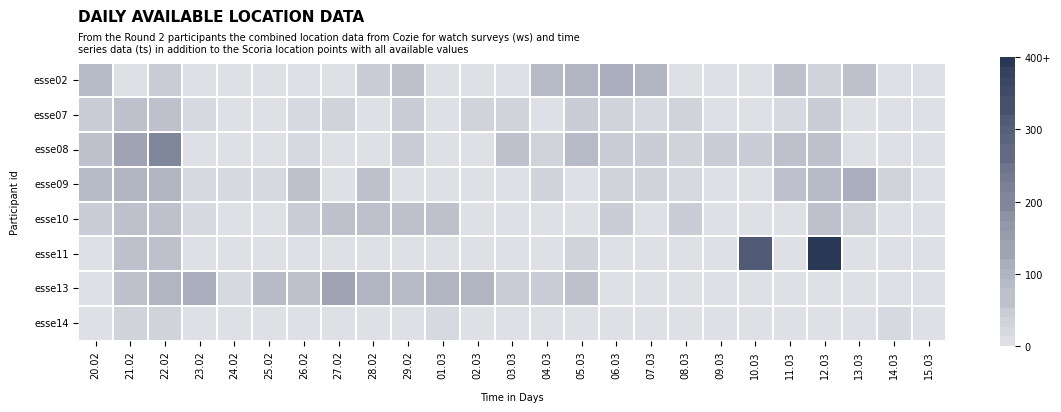

index_time,20.02,21.02,22.02,23.02,24.02,25.02,26.02,27.02,28.02,29.02,...,06.03,07.03,08.03,09.03,10.03,11.03,12.03,13.03,14.03,15.03
id_participant,,,,,,,,,,,,,,,,,,,,,
esse02,84.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,53.0,55.0,...,110.0,104.0,3.0,0.0,0.0,77.0,32.0,78.0,0.0,0.0
esse07,51.0,77.0,66.0,18.0,0.0,0.0,23.0,34.0,0.0,41.0,...,30.0,18.0,31.0,7.0,0.0,18.0,49.0,0.0,0.0,0.0
esse08,64.0,121.0,200.0,11.0,0.0,0.0,23.0,9.0,0.0,45.0,...,53.0,51.0,29.0,53.0,49.0,68.0,73.0,0.0,0.0,0.0
esse09,82.0,104.0,94.0,25.0,25.0,20.0,56.0,4.0,56.0,13.0,...,31.0,28.0,23.0,2.0,4.0,61.0,82.0,114.0,30.0,6.0
esse10,43.0,56.0,60.0,26.0,0.0,0.0,40.0,71.0,54.0,75.0,...,51.0,7.0,48.0,3.0,0.0,0.0,74.0,38.0,0.0,2.0
esse11,0.0,58.0,55.0,12.0,5.0,0.0,11.0,0.0,0.0,1.0,...,8.0,2.0,2.0,0.0,311.0,0.0,420.0,0.0,0.0,0.0
esse13,0.0,78.0,98.0,111.0,22.0,87.0,70.0,128.0,105.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
esse14,0.0,31.0,32.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,15.0,0.0


In [25]:
vmax = 400
step_size = 100
cbar_labels = ['0','100', '200', '300', '400+']
title = 'DAILY AVAILABLE LOCATION DATA'
subtitle = ('From the Round 2 participants the combined location data from Cozie for watch surveys (ws) and time\n'
            'series data (ts) in addition to the Scoria location points with all available values')
xlabel = 'Time in Days'
ylabel = 'Participant id'

# Call the function with appropriate arguments
_modules.StandartHeatmap(
    df=filtered_daily_participant_counts, 
    vmax=vmax, 
    step_size=step_size, 
    cmap=TUMBlueDarkSingleHueScale, 
    cbar_labels=cbar_labels,
    title=title, 
    subtitle=subtitle, 
    xlabel=xlabel, 
    ylabel=ylabel
)

 # STACKED BARCHARTS

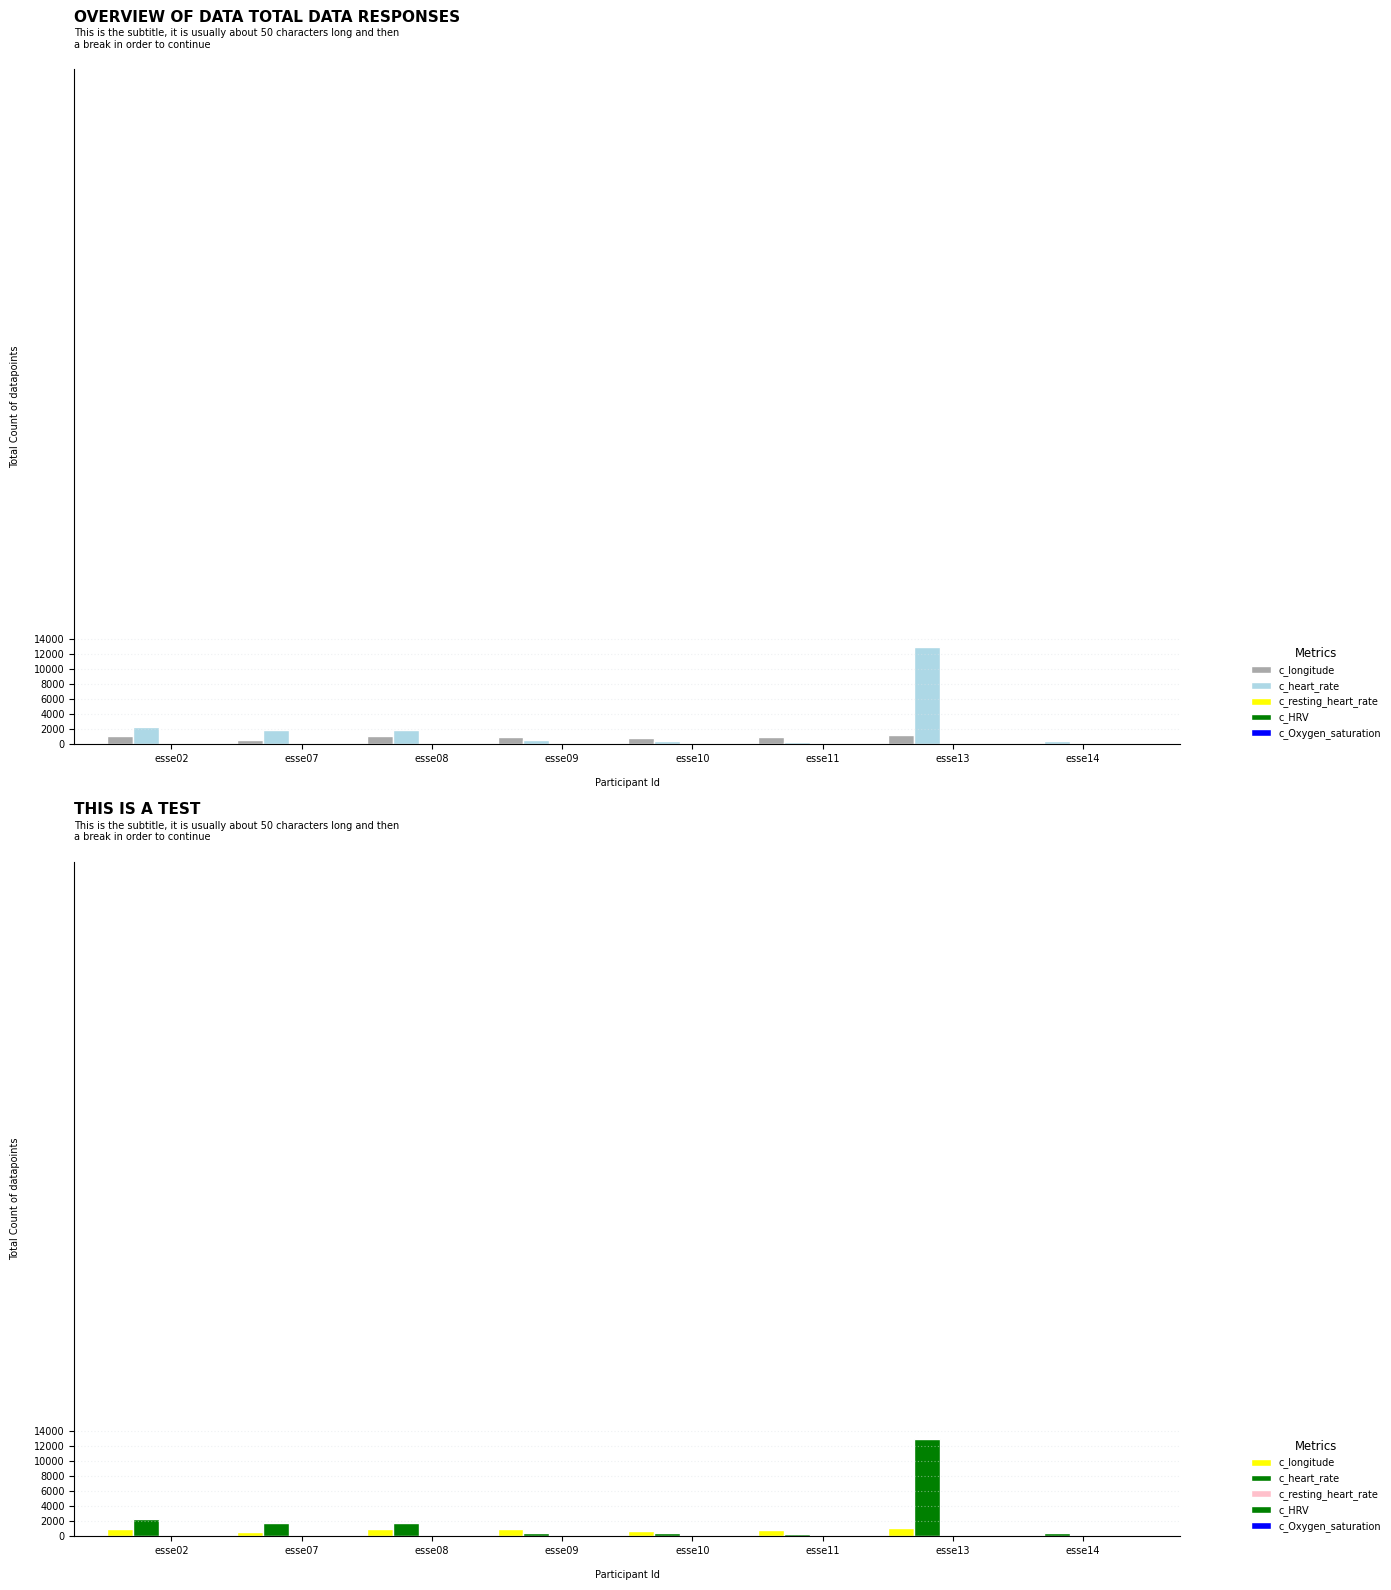

In [27]:
# Plot 1 details
title1 = 'OVERVIEW OF DATA TOTAL DATA RESPONSES'
subtitle1 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel1 = 'Participant Id'
ylabel1 = 'Total Count of datapoints'
colors1 = ['#A9A9A9', '#ADD8E6', '#FFFF00', 'Green', 'Blue']
ymax1 = 90000

# Plot 2 details
title2 = 'THIS IS A TEST'
subtitle2 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel2 = 'Participant Id'
ylabel2 = 'Total Count of datapoints'
colors2 = ['Yellow', "Green", "Pink", 'Green', 'Blue']
ymax2 = 90000

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16), tight_layout=True)

# Generate individual plots
_modules.TLStandardClosedStackedBarchart(axs[0], daily_participant_counts, title1, subtitle1, xlabel1, ylabel1, colors1, ymax1)
_modules.TLStandardClosedStackedBarchart(axs[1], daily_participant_counts, title2, subtitle2, xlabel2, ylabel2, colors2, ymax2)

# Show the figure with subplots
plt.show()

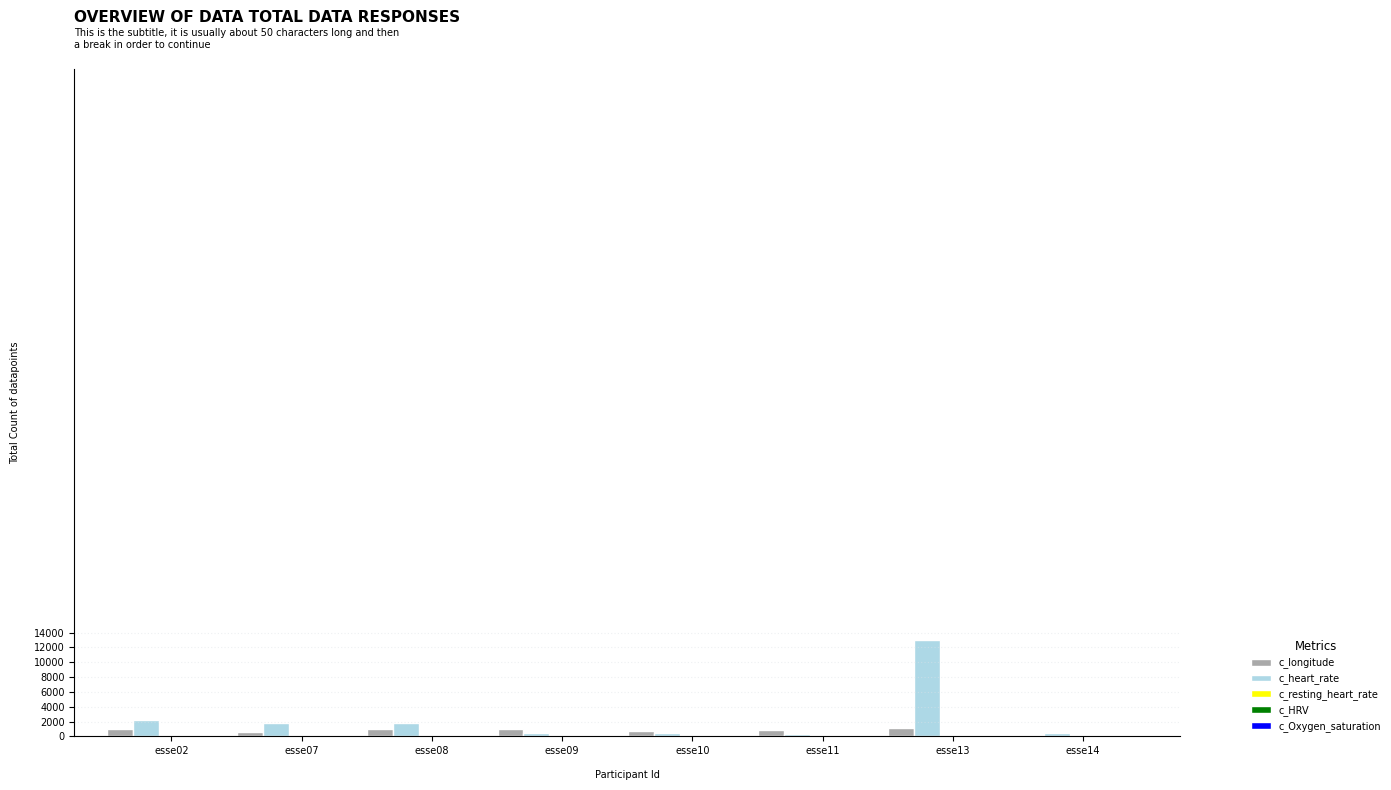

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8), tight_layout=True)

# Generate the individual plot
_modules.TLStandardClosedStackedBarchart(ax, daily_participant_counts, title1, subtitle1, xlabel1, ylabel1, colors1, ymax1)

# Show the figure
plt.show()